In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, date
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import lognorm, norm, triang, genhyperbolic, burr12
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

start = date(1950,1,1)
end = datetime.today()

fred_series = {'yield02':  'WGS2YR',
               'yield30':  'WGS30YR'}


df = web.DataReader(fred_series.values(), 'fred', start, end)
df.columns = fred_series.keys()
df.index.name = 'date'
df.dropna(inplace=True)
spreadName = "spread" + df.columns[1][5:] + "_" + df.columns[0][5:]
df[spreadName] = df[df.columns[1]] - df[df.columns[0]]
df

,yield02,yield30,spread30_02
date,,,
1977-02-18,6.03,7.70,1.67
1977-02-25,6.14,7.80,1.66
1977-03-04,6.11,7.81,1.70
1977-03-11,6.12,7.82,1.70
1977-03-18,6.08,7.78,1.70
...,...,...,...
2022-08-12,3.24,3.06,-0.18
2022-08-19,3.24,3.14,-0.10
2022-08-26,3.34,3.26,-0.08


In [2]:
adf_results = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest']
result=adfuller(df[spreadName])
dict(zip(adf_results, result))

{'adf': -2.6000057372732557,
 'pvalue': 0.09299608166670531,
 'usedlag': 22,
 'nobs': 2355,
 'criticalvalues': {'1%': -3.4331298055777806,
  '5%': -2.862768070104647,
  '10%': -2.567423754896525},
 'icbest': -4171.175152135478}

The fact that ```pvalue``` is above 0.05 indicates lack of stationarity.

In [3]:
sprd_chg = df[spreadName].diff()
sprd_chg.dropna(inplace=True)
sprd_chg

date
1977-02-25   -1.000000e-02
1977-03-04    4.000000e-02
1977-03-11    8.881784e-16
1977-03-18    0.000000e+00
1977-03-25    1.000000e-02
                  ...     
2022-08-12   -9.000000e-02
2022-08-19    8.000000e-02
2022-08-26    2.000000e-02
2022-09-02   -8.000000e-02
2022-09-09    1.200000e-01
Freq: W-FRI, Name: spread30_02, Length: 2377, dtype: float64

In [4]:
result=adfuller(sprd_chg)
dict(zip(adf_results, result))

{'adf': -12.980385381844634,
 'pvalue': 2.952166885836075e-24,
 'usedlag': 17,
 'nobs': 2359,
 'criticalvalues': {'1%': -3.433125086901646,
  '5%': -2.8627659864448662,
  '10%': -2.5674226455102995},
 'icbest': -4164.877697969052}

```pvalue``` is now down below 0.05 and ```sprd_chg``` is considered stationary.

/home/catweazle/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


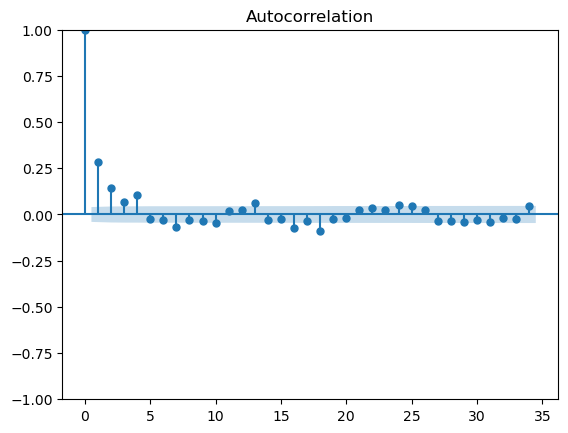

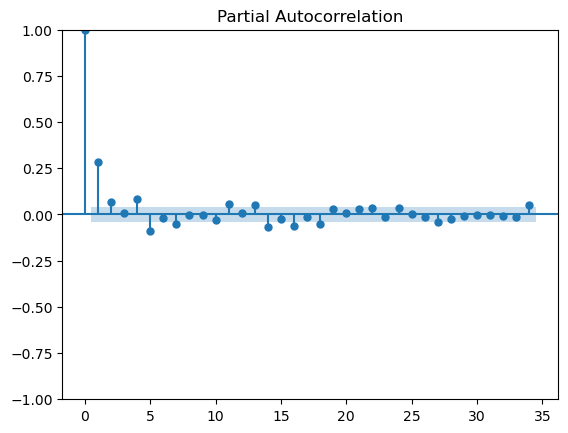

In [17]:
fig1=plot_acf(sprd_chg)
fig2=plot_pacf(sprd_chg)

In [18]:
mod = sm.tsa.ARIMA(df[spreadName], order = (4,1,6))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            spread30_02   No. Observations:                 2378
Model:                 ARIMA(4, 1, 6)   Log Likelihood                2123.584
Date:                Fri, 16 Sep 2022   AIC                          -4225.169
Time:                        15:04:01   BIC                          -4161.659
Sample:                    02-18-1977   HQIC                         -4202.053
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3027      0.395      0.766      0.444      -0.472       1.078
ar.L2          0.5336      0.323      1.653      0.098      -0.099       1.166
ar.L3         -0.3770      0.121     -3.110      0.0

/home/catweazle/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:ylabel='Density'>

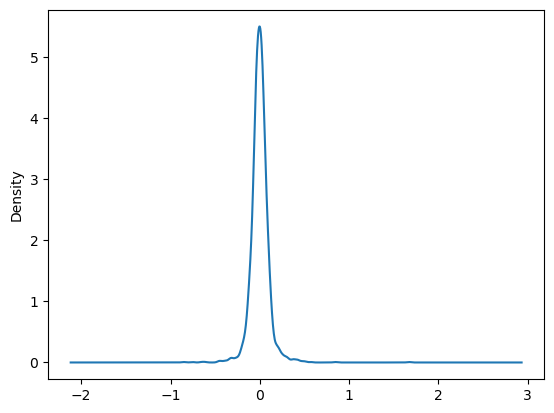

In [19]:
res.resid.plot(kind='kde')

In [20]:
res.resid

date
1977-02-18    1.670000
1977-02-25   -0.010000
1977-03-04    0.042820
1977-03-11   -0.009846
1977-03-18   -0.002573
                ...   
2022-08-12   -0.038915
2022-08-19    0.114931
2022-08-26    0.000091
2022-09-02   -0.056271
2022-09-09    0.132803
Freq: W-FRI, Length: 2378, dtype: float64

In [21]:
sprd_chg.describe()

count    2377.000000
mean       -0.000719
std         0.104800
min        -0.860000
25%        -0.050000
50%         0.000000
75%         0.050000
max         0.810000
Name: spread30_02, dtype: float64

/home/catweazle/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/catweazle/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhyperbolic,0.578934,957.871915,-19747.474581,inf,0.011909,0.884605
t,0.610766,975.730420,-19635.736943,inf,0.011271,0.919754
johnsonsu,0.863406,1053.142709,-18804.768108,inf,0.013719,0.756552
hypsecant,0.979079,1975.361869,-18521.336817,inf,0.026043,0.078065
tukeylambda,1.026982,1025.030541,-18399.973830,inf,0.024098,0.124284


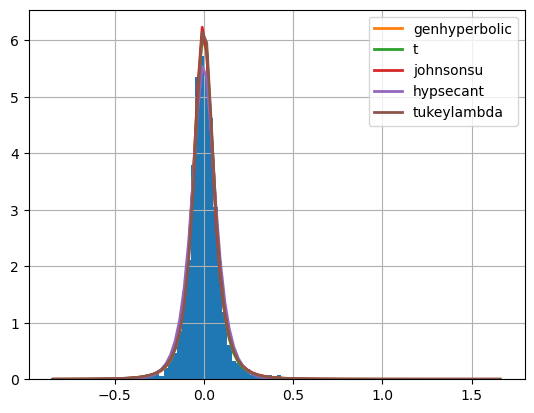

In [22]:
f = Fitter(res.resid,
          distributions=get_distributions())
f.fit()
f.summary()

In [23]:
best = f.get_best(method = 'sumsquare_error')
best_distro = list(best.keys())[0]
best_distro

'genhyperbolic'

In [24]:
best_parms  = best[best_distro]
best_parms

{'p': -1.4779771225986371,
 'a': 0.043233369078007344,
 'b': 0.03730389576401921,
 'loc': -0.003639680634419604,
 'scale': 0.10267662996013979}

In [25]:
randos = genhyperbolic.rvs(**best_parms,size=1000)

In [26]:
randos

array([ 2.02931923e-02,  2.22221656e-02, -9.37955243e-02, -1.01878735e-01,
        1.45384457e-02, -2.01754478e-02, -6.16896961e-02,  3.41236155e-02,
       -2.55688118e-02, -3.00348498e-02, -2.32790016e-03, -5.81275032e-02,
        3.32578249e-02,  9.12357306e-02, -3.25325719e-02,  3.13749949e-02,
        1.69010185e-01, -5.16150631e-02,  1.36822851e-01,  6.78608523e-02,
        3.19020393e-02,  3.48976144e-01, -6.80645281e-03,  1.44851617e-01,
       -1.04400441e-02, -1.69768662e-02, -3.33032583e-02, -8.14491896e-02,
       -1.04717933e-01, -7.29265500e-02, -1.76983498e-02,  2.40085763e-02,
       -1.45633416e-03, -8.26252100e-03,  8.97221338e-02,  9.39594710e-02,
       -3.27559215e-03,  6.10410243e-02, -1.01117019e-02, -1.77591386e-02,
       -7.93206451e-02, -1.71961892e-01, -6.95898199e-03, -3.87844566e-02,
       -1.11980222e-01,  2.96554392e-02, -1.08186151e-01,  7.86444870e-02,
       -3.12184560e-02,  4.71902730e-02, -9.77093308e-03, -1.33586251e-01,
       -3.87202472e-03, -

In [27]:
genhyperbolic.rvs(**best_parms)

-0.27433878214801694

In [31]:
np.percentile(randos, 15.75)

-0.07864331848919773

/home/catweazle/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/catweazle/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [30]:
np.percentile(randos, 84.25)

0.07327295204621284